# Bank Marketing Dataset Analysis and Prediction Model

**Disclaimer**: The notebook was originaly the work of data science bootcamp final project, but personally enhanced and refined by me. 
The team consists Muhammad Ilham, Ananda Farhad Habibie, Zara Maghfira and myself.

The Dataset was taken from [https://www.kaggle.com/dhirajnirne/bank-marketing](https://www.kaggle.com/dhirajnirne/bank-marketing)

## Preparation

### Import Libraries

In [69]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
import datetime
from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


python version:  3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas version:  1.1.3
seaborn version:  0.11.0
last run:  2021-11-11 16:09:39


### Loading Dataset

In [70]:
df = pd.read_csv("bank-marketing.csv")

# developer-friendly column names and format
df.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in df.columns.to_list()]

df.sample(5, random_state=1)

,age,age_group,eligible,job,salary,marital,education,marital_education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,response
3610,42,4,Y,blue-collar,20000,married,primary,married-primary,yes,no,2519,yes,no,unknown,15,may,262,4,-1,0,unknown,no,0
11677,37,3,Y,technician,60000,married,secondary,married-secondary,yes,no,2209,no,no,unknown,20,jun,167,2,-1,0,unknown,no,0
33018,32,3,Y,admin.,50000,married,secondary,married-secondary,yes,no,923,yes,no,cellular,17,apr,819,4,-1,0,unknown,no,0
44323,53,5,Y,blue-collar,20000,married,primary,married-primary,yes,no,306,no,no,cellular,28,jul,388,3,181,1,success,yes,1
8119,32,3,Y,technician,60000,single,tertiary,single-tertiary,no,no,257,yes,no,unknown,2,jun,183,5,-1,0,unknown,no,0


## Data Information & Description

### Data Sample

In [71]:
df.sample(5, random_state=1)

,age,age_group,eligible,job,salary,marital,education,marital_education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,response
3610,42,4,Y,blue-collar,20000,married,primary,married-primary,yes,no,2519,yes,no,unknown,15,may,262,4,-1,0,unknown,no,0
11677,37,3,Y,technician,60000,married,secondary,married-secondary,yes,no,2209,no,no,unknown,20,jun,167,2,-1,0,unknown,no,0
33018,32,3,Y,admin.,50000,married,secondary,married-secondary,yes,no,923,yes,no,cellular,17,apr,819,4,-1,0,unknown,no,0
44323,53,5,Y,blue-collar,20000,married,primary,married-primary,yes,no,306,no,no,cellular,28,jul,388,3,181,1,success,yes,1
8119,32,3,Y,technician,60000,single,tertiary,single-tertiary,no,no,257,yes,no,unknown,2,jun,183,5,-1,0,unknown,no,0


### Columns Description

| Column | Description | Type |
| --- | ----------- | ------- |
| age | Customer's Age | numerical - discrete |
| age_group | Customer's Age in Group | categorical - ordinal |
| eligible | ? | categorical - binary |
| job | Customer's job or occupation | categorical - nominal |
| salary | Customer's salary | numerical - continuous |
| marital | Customer's marital status | categorical - nominal |
| education | Customer's education level | categorical - ordinal |
| marital_education | marital + education | categorical - nominal |
| targeted | ? | categorical - binary |
| default | ? | categorical - binary |
| balance | Customer's account balance | numerical - continuous |
| housing | Customer has house or not | categorical - binary |
| loan | Customer has loan or not | categorical - binary |
| contact | Customer's Age in Group | categorical - nominal |
| day | The day customer was contacted | categorical - nominal |
| month | The month customer was contacted | categorical - nominal |
| duration | ? | numerical - continuous |
| campaign | The campaign given to the customer | categorical - nominal |
| pdays | ? | numerical - continuous |
| previous | The previous campaign given to the customer | categorical - nominal |
| poutcome | The result on previous campaign | categorical - nominal |
| y | Customer's response. Value in `yes` or `no` | categorical - binary |
| response | Customer's response. Value in `1` or `0` | categorical - binary |

### Data Information

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                45211 non-null  int64 
 1   age_group          45211 non-null  int64 
 2   eligible           45211 non-null  object
 3   job                45211 non-null  object
 4   salary             45211 non-null  int64 
 5   marital            45211 non-null  object
 6   education          45211 non-null  object
 7   marital_education  45211 non-null  object
 8   targeted           45211 non-null  object
 9   default            45211 non-null  object
 10  balance            45211 non-null  int64 
 11  housing            45211 non-null  object
 12  loan               45211 non-null  object
 13  contact            45211 non-null  object
 14  day                45211 non-null  int64 
 15  month              45211 non-null  object
 16  duration           45211 non-null  int64

## Preprocessing

### Find Duplicated Data

In [73]:
df.duplicated().sum()

0

There is no duplicated data

### Find Missing Value

In [74]:
df.isna().sum()

age                  0
age_group            0
eligible             0
job                  0
salary               0
marital              0
education            0
marital_education    0
targeted             0
default              0
balance              0
housing              0
loan                 0
contact              0
day                  0
month                0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
y                    0
response             0
dtype: int64

There is no missing value

### Converting `unknown` value of `poutcome` into `other`

In [75]:
df['poutcome'] = df['poutcome'].apply(lambda poutcome: 'other' if poutcome == 'unknown' else poutcome)
df['poutcome'].unique()

array(['other', 'failure', 'success'], dtype=object)

## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [76]:
df.select_dtypes(include='number').describe()

,age,age_group,salary,balance,day,duration,campaign,pdays,previous,response
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,3.645861,57006.171065,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,1.083271,32085.718415,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,1.000000,0.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,3.000000,20000.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,3.000000,60000.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,4.000000,70000.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,9.000000,120000.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


#### Categorical

In [77]:
df.select_dtypes(exclude='number').describe()

,eligible,job,marital,education,marital_education,targeted,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,2,12,3,4,12,2,2,2,2,3,12,3,2
top,Y,blue-collar,married,secondary,married-secondary,yes,no,yes,no,cellular,may,other,no
freq,43380,9732,27214,23202,13770,37091,44396,25130,37967,29285,13766,38799,39922


### Univariate Analysis

#### Distribution Plot of Numerical Features

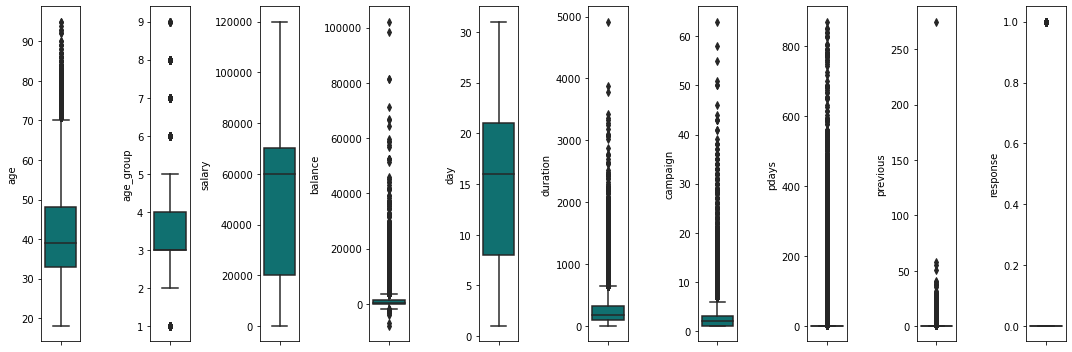

In [78]:
idf = df.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(15, 5))
for i in range(0, len(cols)):
    plt.subplot(1, len(cols), i+1)
    sns.boxplot(y=df[cols[i]], color='teal', orient='v')
    plt.tight_layout()

plt.show();


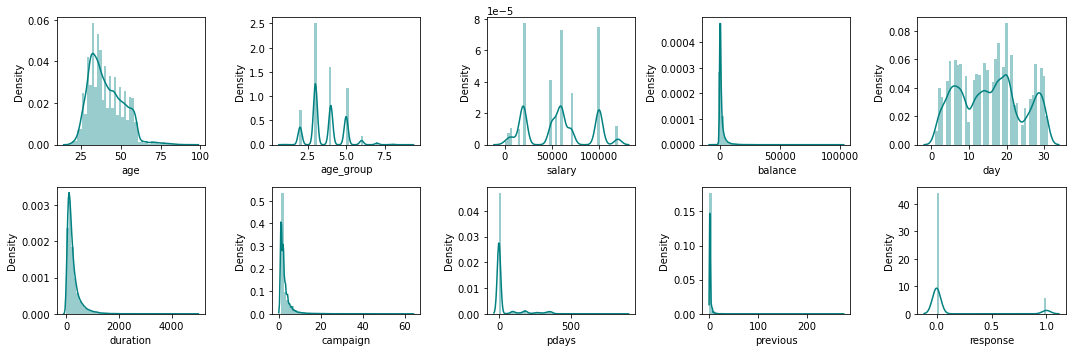

In [79]:
idf = df.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(15, 5))
for i in range(0, len(cols)):
    plt.subplot(2, len(cols)/2, i+1)
    sns.distplot(df[cols[i]], color='teal')
    plt.tight_layout()

plt.show();


#### Count Plot For Categorical Features

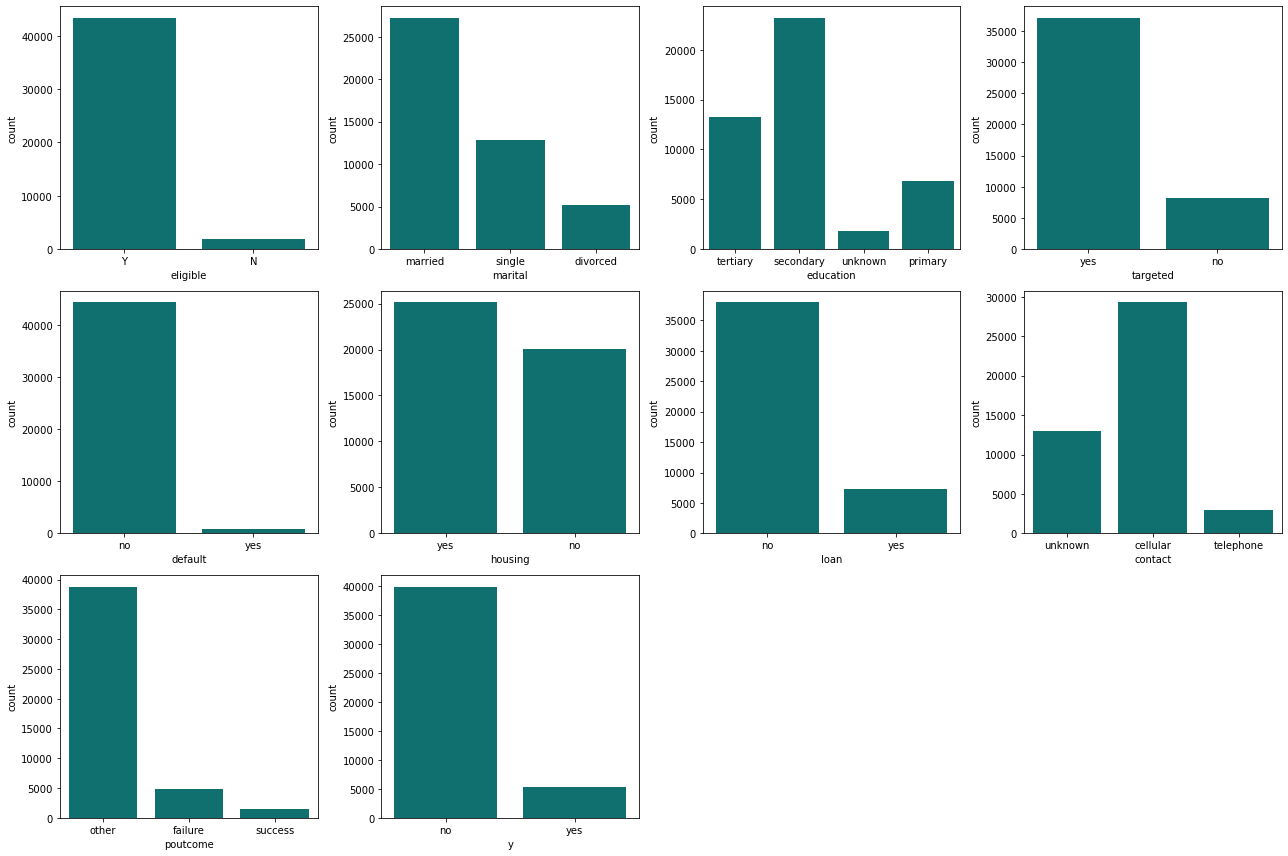

In [80]:
idf = df.select_dtypes(include='object')
cols = idf.columns.to_list()

more_group = []
less_group = []
for col in cols:
    if (len(df[col].unique().tolist()) > 5):
        more_group.append(col)
    else:
        less_group.append(col)


plt.figure(figsize=(18, 12))
for i in range(0, len(less_group)):
    plt.subplot(len(less_group) / 3, 4, i+1)
    sns.countplot(df[less_group[i]], color='teal', orient='v')
    plt.tight_layout()

plt.show();

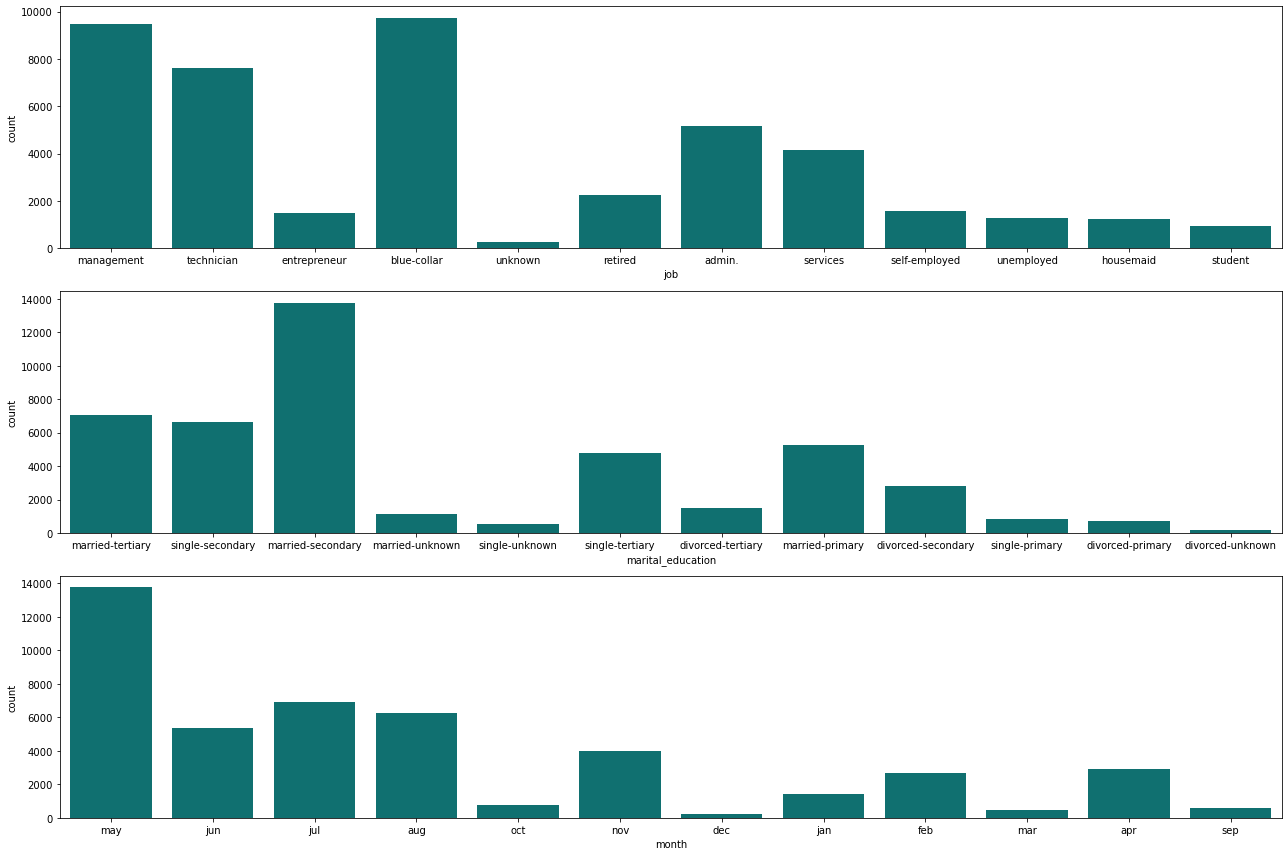

In [81]:
plt.figure(figsize=(18, 12))
for i in range(0, len(more_group)):
    plt.subplot(len(more_group), 1, i+1)
    sns.countplot(df[more_group[i]], color='teal', orient='v')
    plt.tight_layout()

plt.show();


### Multivariate Analysis

#### Correlation Heatmap

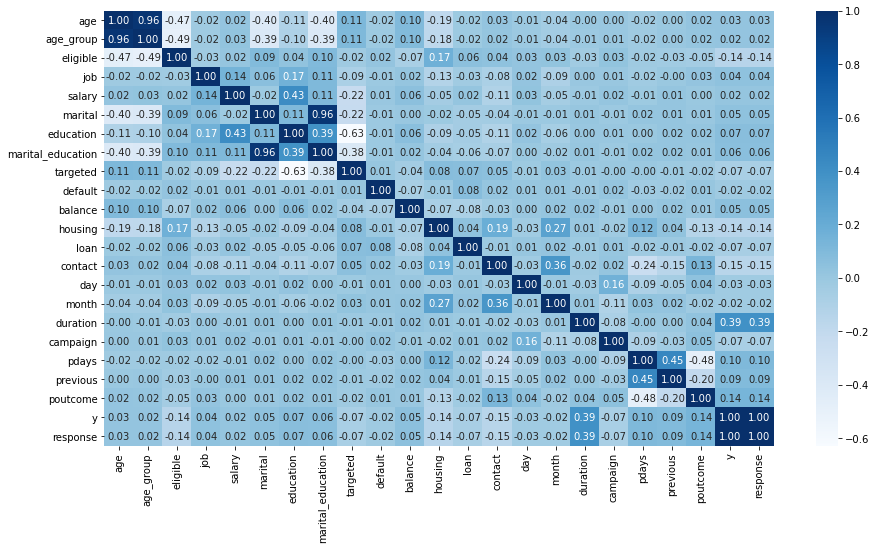

In [82]:
# label encoding for heatmap
df_encoded = df.copy()
for feature in df_encoded.select_dtypes(include='object').columns.tolist():
    df_encoded[feature] = df_encoded[feature].astype('category').cat.codes


plt.figure(figsize=(15, 8))
sns.heatmap(df_encoded.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

- **response** and **y** has perfect correlation, they could be the same thing
- **age** and **age_group** almost identical, because of strong correlation
- **marital** and **marital_education** almost identical, because of strong correlation

In [83]:
# sns.pairplot(data=df_encoded.sample(1000, random_state=1)) # takes long time to run, and hard to read

### Insights

#### Response Imbalance

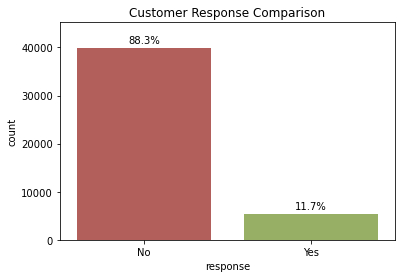

In [84]:
df_for_plot = df.groupby(['response']).agg({'response': 'count'}).rename(columns={'response': 'count'}).reset_index()
df_for_plot['percentage'] = df_for_plot['count'].apply(lambda x: round(x / df_for_plot['count'].sum(), 3) * 100)

sns.barplot(
    x='response',
    y='count',
    palette=['#C0504D', '#9BBB59'],
    data=df_for_plot
)
plt.xticks(ticks=[0,1], labels=['No','Yes'])
plt.title('Customer Response Comparison')
plt.ylim((0, df_for_plot['count'].sum()))

for index,row in df_for_plot.iterrows():
    plt.text(x=row['response'], y=row['count'] + 1000, s=f"{str(round(row['percentage'], 3))}%", ha='center')

plt.show();

#### Duration Distribution with Response

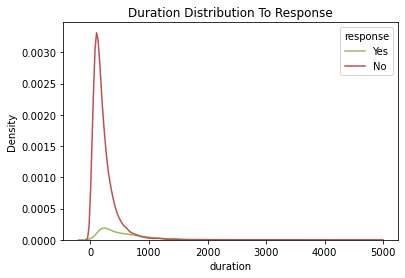

In [85]:
sns.kdeplot(
    x='duration', 
    hue='response', 
    palette=['#C0504D', '#9BBB59'],
    data=df
)
plt.title('Duration Distribution To Response')
legend = plt.legend(labels=['Yes', 'No'])
legend.set_title('response')
plt.show();

#### Previous Outcome Comparison with Response

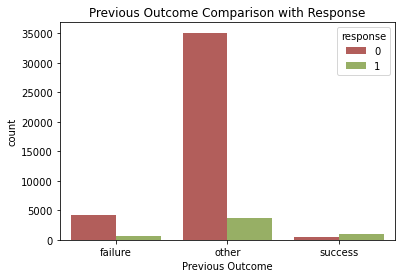

In [86]:
df_for_plot = df.groupby(['poutcome','response']).agg({'response': 'count'}).rename(columns={'response': 'count'}).reset_index()
df_for_plot = df_for_plot.merge(
    df.groupby(['poutcome']).agg('count').rename(columns={'age': 'total_count'}).reset_index()[['poutcome', 'total_count']],
    on='poutcome'
)
df_for_plot['percentage'] = df_for_plot['count'] / df_for_plot['total_count']

sns.barplot(x='poutcome', y='count', hue='response', palette=['#C0504D', '#9BBB59'], data=df_for_plot)
plt.xlabel('Previous Outcome')

# for index, row in df_for_plot.iterrows():
#     plt.text(x=row['poutcome'], y=row['count'] + 1000, s=row['percentage'], ha='center')

plt.title('Previous Outcome Comparison with Response')
plt.show();